In [76]:
import os
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator



import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.utils import plot_model
import tensorflow.keras.layers as Layers
import keras.backend as K

# CUDA

In [77]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Custom Metrics

In [78]:
smooth = 100
def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def dice_coef(y_true, y_pred):
    y_truef = K.flatten(y_true)
    y_predf = K.flatten(y_pred)
    And = K.sum(y_truef * y_predf)
    return((2 * And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))


# Network

In [79]:
def build_unet(dropout):
    
    input = Layers.Input((128, 128, 3))
    conv1_1 = Layers.Conv2D(32, 3, activation = 'relu', padding = 'same')(input)
    drop1_1 = Layers.Dropout(dropout)(conv1_1)
    conv1_2 = Layers.Conv2D(32, 3, activation = 'relu', padding = 'same')(drop1_1)
    drop1_2 = Layers.Dropout(dropout)(conv1_2)
    
    pool1 = Layers.MaxPooling2D(pool_size=(2, 2))(drop1_2)
    conv2_1 = Layers.Conv2D(64, 3, activation = 'relu', padding = 'same')(pool1)
    drop2_1 = Layers.Dropout(dropout)(conv2_1)
    conv2_2 = Layers.Conv2D(64, 3, activation = 'relu', padding = 'same')(drop2_1)
    drop2_2= Layers.Dropout(dropout)(conv2_2)

    pool2 = Layers.MaxPooling2D(pool_size=(2, 2))(drop2_2)
    conv3_1 = Layers.Conv2D(128, 3, activation = 'relu', padding = 'same')(pool2)
    drop3_1 = Layers.Dropout(dropout)(conv3_1)
    conv3_2 = Layers.Conv2D(128, 3, activation = 'relu', padding = 'same')(drop3_1)
    drop3_2 = Layers.Dropout(dropout)(conv3_2)
    
    pool3 = Layers.MaxPooling2D(pool_size=(2, 2))(drop3_2)
    conv4_1 = Layers.Conv2D(256, 3, activation = 'relu', padding = 'same')(pool3)
    drop4_1 = Layers.Dropout(dropout)(conv4_1)
    conv4_2 = Layers.Conv2D(256, 3, activation = 'relu', padding = 'same')(drop4_1)
    drop4_2 = Layers.Dropout(dropout)(conv4_2)
    
    
    pool4 = Layers.MaxPooling2D(pool_size=(2, 2))(drop4_2)
    conv5_1 = Layers.Conv2D(512, 3, activation = 'relu', padding = 'same')(pool4)
    drop5_1 = Layers.Dropout(dropout)(conv5_1)
    conv5_2 = Layers.Conv2D(512, 3, activation = 'relu', padding = 'same')(drop5_1)
    drop5_2 = Layers.Dropout(dropout)(conv5_2)

    up1 = Layers.Conv2D(256, 2, activation = 'relu', padding = 'same')(Layers.UpSampling2D(size = (2,2))(drop5_2))
    merge1 = Layers.concatenate([drop4_2, up1], axis = 3)
    conv6_1 = Layers.Conv2D(256, 3, activation = 'relu', padding = 'same')(merge1)
    drop6_1 = Layers.Dropout(dropout)(conv6_1)
    conv6_2 = Layers.Conv2D(256, 3, activation = 'relu', padding = 'same')(drop6_1)
    drop6_2 = Layers.Dropout(dropout)(conv6_2)

    up2 = Layers.Conv2D(128, 2, activation = 'relu', padding = 'same')(Layers.UpSampling2D(size = (2,2))(drop6_2))
    merge2 = Layers.concatenate([drop3_2, up2], axis = 3)
    conv7_1 = Layers.Conv2D(128, 3, activation = 'relu', padding = 'same')(merge2)
    drop7_1 = Layers.Dropout(dropout)(conv7_1)
    conv7_2 = Layers.Conv2D(128, 3, activation = 'relu', padding = 'same')(drop7_1)
    drop7_2 = Layers.Dropout(dropout)(conv7_2)

    up3 = Layers.Conv2D(64, 2, activation = 'relu', padding = 'same')(Layers.UpSampling2D(size = (2,2))(drop7_2))
    merge3 = Layers.concatenate([drop2_2, up3], axis = 3)
    conv8_1 = Layers.Conv2D(64, 3, activation = 'relu', padding = 'same')(merge3)
    drop8_1 = Layers.Dropout(dropout)(conv8_1)
    conv8_2 = Layers.Conv2D(64, 3, activation = 'relu', padding = 'same')(drop8_1)
    drop8_2 = Layers.Dropout(dropout)(conv8_2)
    
    up4 = Layers.Conv2D(32, 2, activation = 'relu', padding = 'same')(Layers.UpSampling2D(size = (2,2))(drop8_2))
    merge4 = Layers.concatenate([drop1_2, up4], axis = 3)
    conv9_1 = Layers.Conv2D(32, 3, activation = 'relu', padding = 'same')(merge4)
    drop9_1 = Layers.Dropout(dropout)(conv9_1)
    conv9_2 = Layers.Conv2D(32, 3, activation = 'relu', padding = 'same')(drop9_1)
    drop9_2 = Layers.Dropout(dropout)(conv9_2)
    
    output = Layers.Conv2D(1, (1,1), activation = 'sigmoid')(drop9_2)
    
    return keras.models.Model(inputs = input, outputs = output)


model = build_unet(0.2)


In [80]:
# model.summary()

In [81]:
# plot_model(
#     model, 
#     show_shapes = True,
#     show_dtype=False,
#     show_layer_names = True, 
#     rankdir = 'TB', 
#     expand_nested = False, 
#     dpi = 100
# )

# Data Schema

In [82]:
def read_image(image_path, mask_mask):
	x = cv2.imread(image_path, cv2.IMREAD_COLOR)
	x = cv2.resize(x, (128, 128))
	x = x.astype(np.float32)
	
	y = cv2.imread(mask_mask, cv2.IMREAD_GRAYSCALE)
	y = cv2.resize(y, (128, 128))
	y = y.astype(np.float32)

	return x, y

In [83]:
def data_path(main_folder_path):
    image_paths = []
    mask_paths = []

    for subfolder_name in os.listdir(main_folder_path):
        subfolder_path = os.path.join(main_folder_path, subfolder_name)
        
        if os.path.isdir(subfolder_path):
            
            for image_filename in os.listdir(subfolder_path):
                if image_filename.endswith('.tif') and not image_filename.endswith('mask.tif'):
                    image_id = os.path.splitext(image_filename)[0]
                    mask_filename = f'{image_id}_mask.tif'  
                    
                    image_path = os.path.join(subfolder_path, image_filename)
                    mask_path = os.path.join(subfolder_path, mask_filename)

                    image_paths.append(image_path)
                    mask_paths.append(mask_path)
                    

    return pd.DataFrame(data={
        'image': image_paths,
        'mask': mask_paths
    })
    

In [84]:
data = data_path(main_folder_path = '../data/MRI/')

In [85]:
def is_tumor(dest_path):
    value = np.max(cv2.imread(dest_path))
    if value > 0 : 
        return 1
    else:
        return 0

data['tumor'] = data['mask'].apply(lambda x: is_tumor(x))

In [86]:
data['tumor'].value_counts()

tumor
0    2556
1    1373
Name: count, dtype: int64

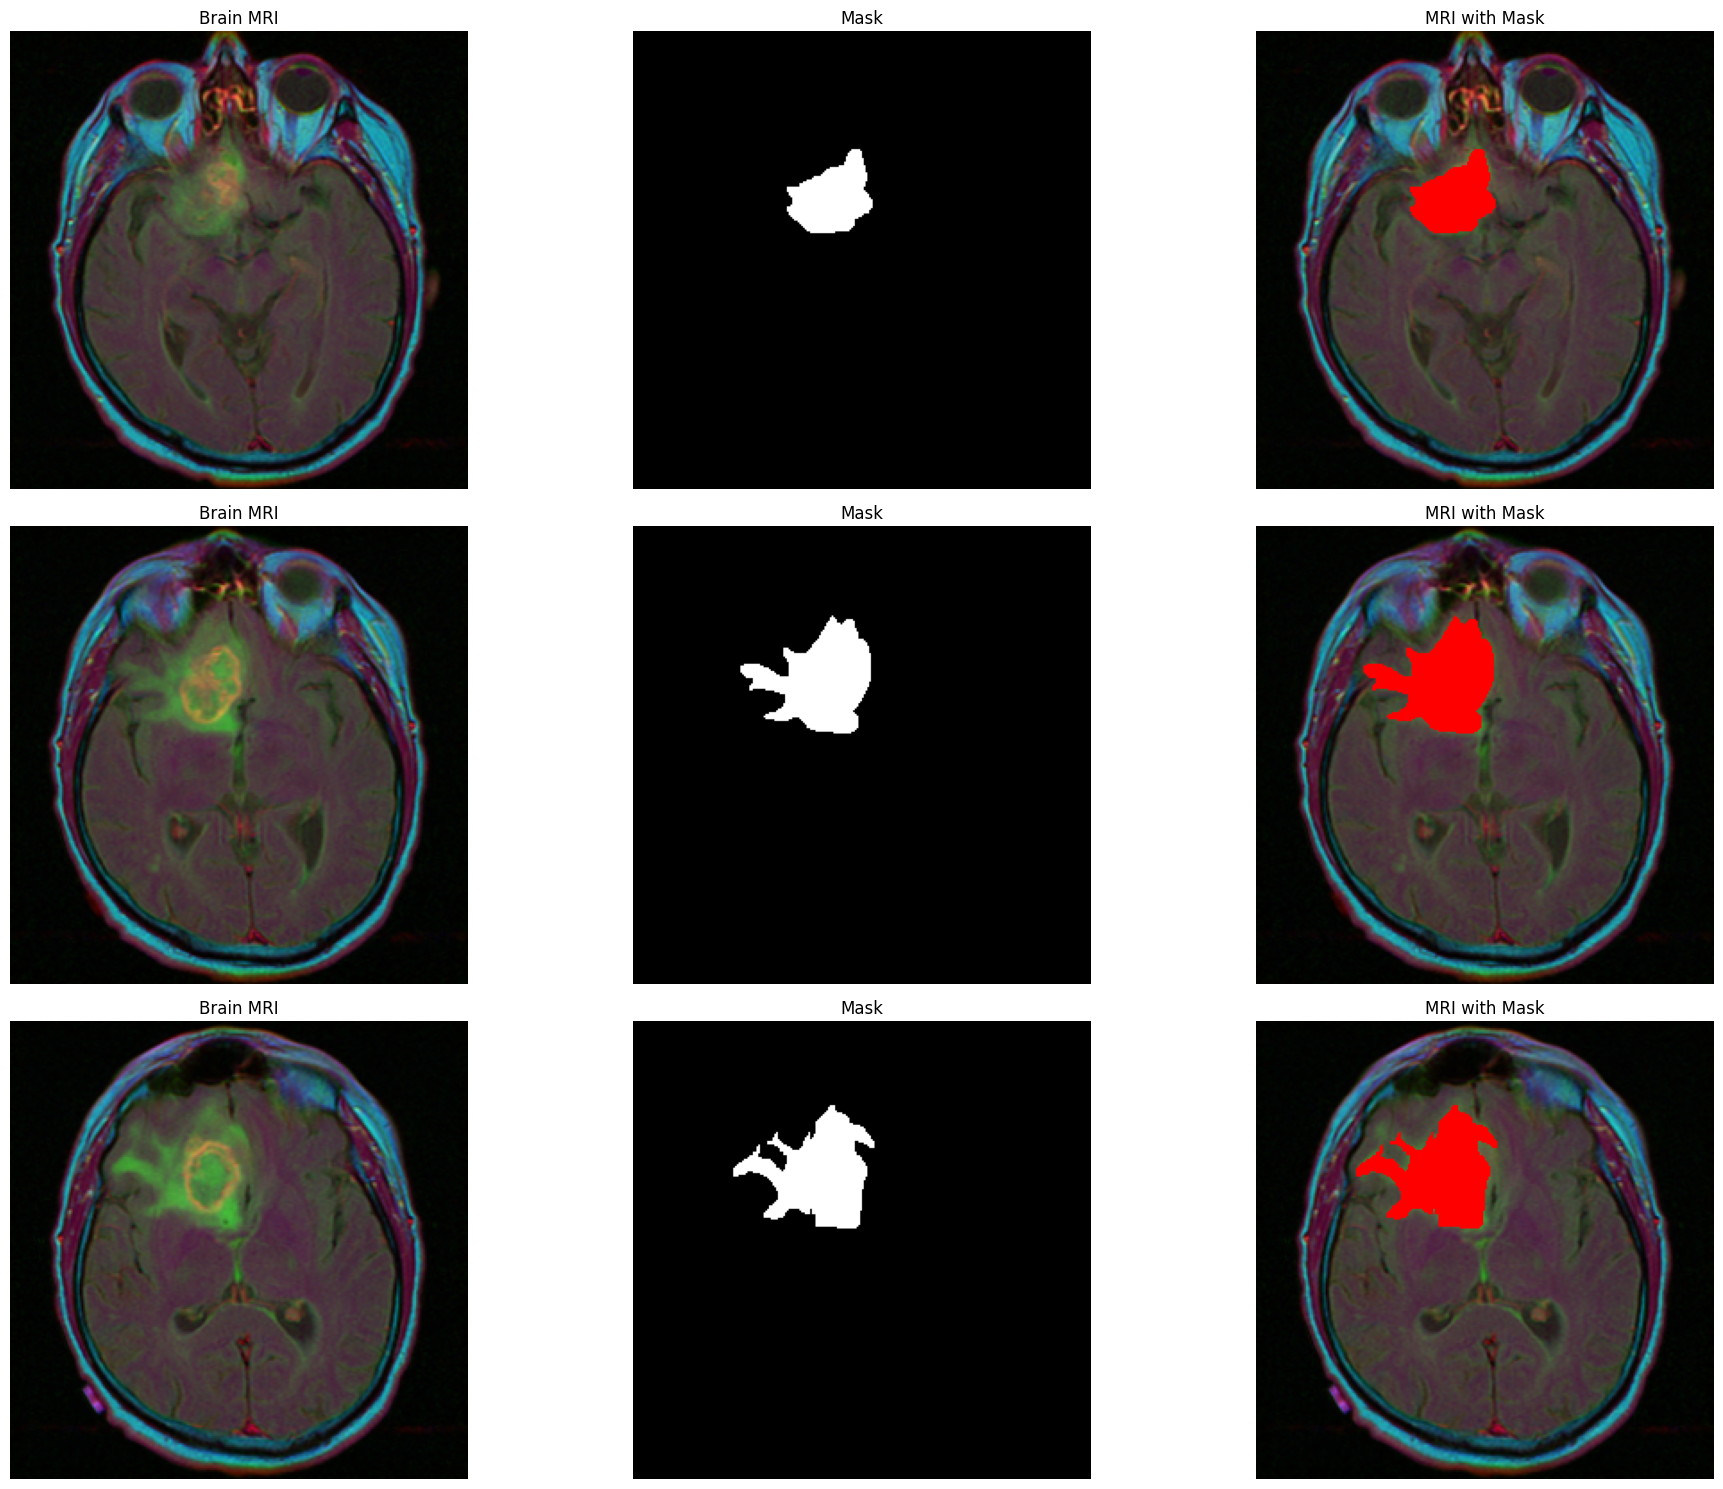

In [87]:
fig, axs = plt.subplots(3, 3, figsize=(20,15))
pos = data[data['tumor'] == 1]
for i in range(3):
	img = cv2.imread(pos.iloc[i]['image'])
	axs[i][0].title.set_text("Brain MRI")
	axs[i][0].axis('off')
	axs[i][0].imshow(img)
	
	mask = cv2.imread(pos.iloc[i]['mask'])
	axs[i][1].title.set_text('Mask')
	axs[i][1].axis('off')
	axs[i][1].imshow(mask, cmap='gray')
	
	tumor_area = mask[:, :, 0] == 255
	img[:, :, :3][tumor_area] = [255, 0, 0] 
	axs[i][2].axis('off')
	axs[i][2].title.set_text('MRI with Mask')
	axs[i][2].imshow(img)

        
fig.tight_layout()
plt.show()

# Data for Network

In [88]:
def adjust_data(img, mask):
    img = img / 255.0
    mask = mask / 255.0
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return img, mask

In [89]:
def data_generator(dataframe, batch_size, aug_dict):

    target_size = (128, 128)
    seed = 1
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        dataframe,
        x_col = 'image',
        class_mode = None,
        color_mode = 'rgb',
        target_size = target_size,
        batch_size = batch_size,
        seed = seed
    )

    mask_generator = mask_datagen.flow_from_dataframe(
        dataframe,
        x_col = 'mask',
        class_mode = None,
        color_mode = 'grayscale',
        target_size = target_size,
        batch_size = batch_size,
        seed = seed
    )

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img, mask)

In [90]:
train, _ = train_test_split(data, test_size=0.2, random_state=42)
valid, test = train_test_split(_, test_size=0.5, random_state=42)

# Data Augmentation

- `rotation_range`: Specify the range of degrees for random rotations applied to the images and masks. This can help introduce diversity in the dataset and make the model more robust to different orientations.

- `width_shift_range` and `height_shift_range`: Define the range as a fraction of total width or height within which to randomly translate the images and masks horizontally or vertically. This augmentation can simulate slight movements or shifts in the objects of interest.

- `shear_range`: Apply random shearing transformations to the images and masks. Shearing can distort the objects and add variability to the dataset, helping the model generalize better.

- `zoom_range`: Randomly zoom the images and masks within a specified range. This augmentation can simulate different scales of objects and improve the model's ability to handle variations in object size.

- `horizontal_flip` and `vertical_flip`: Enable horizontal and vertical flipping of the images and masks. This augmentation can help the model learn from mirrored or upside-down versions of objects, making it more 
invariant to such transformations.

- `brightness_range`: Define a range within which to randomly adjust the brightness of the images. This augmentation can simulate different lighting conditions and enhance the model's ability to handle varying levels of illumination.

In [91]:
aug_methods = dict(
    rotation_range=45,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=(0.8, 1.2)
)

In [92]:
augment_samples = next(data_generator(
    dataframe = train,
    batch_size = 16,
    aug_dict = aug_methods
))

Found 3143 validated image filenames.
Found 3143 validated image filenames.


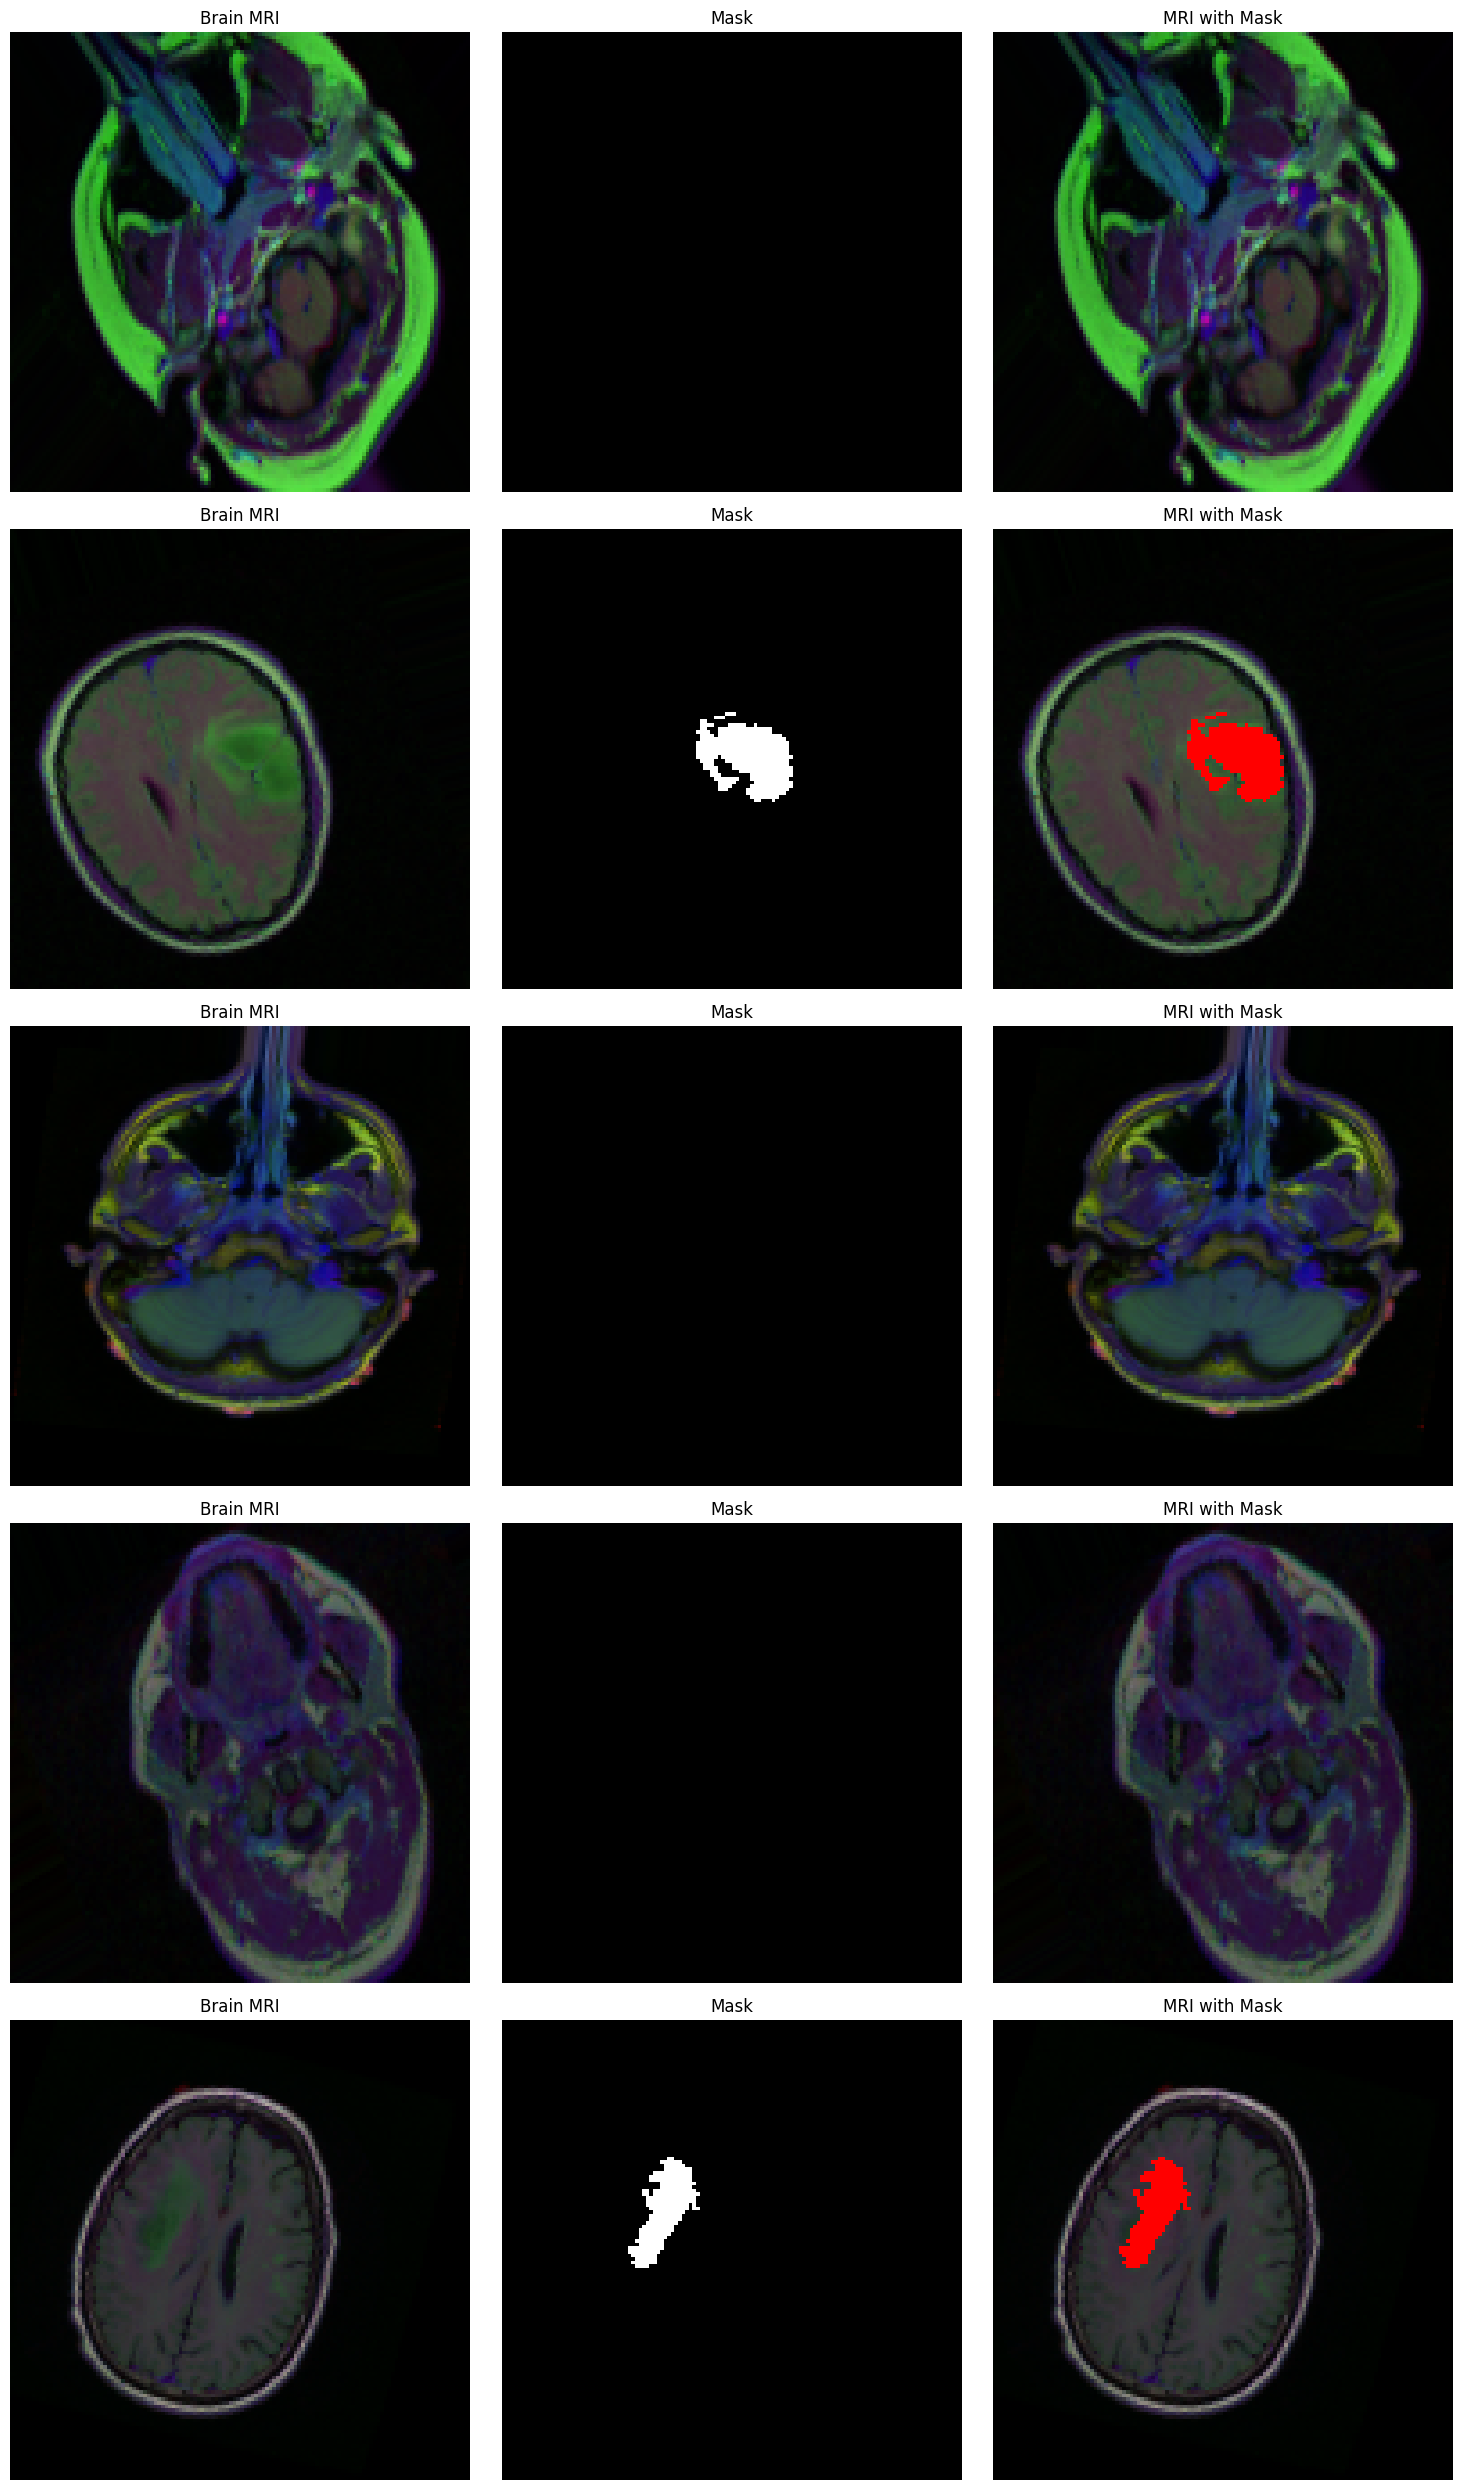

In [93]:
fig, axs = plt.subplots(5, 3, figsize=(15, 25))
for i in range(5):
	img = augment_samples[0][i]
	axs[i][0].title.set_text("Brain MRI")
	axs[i][0].axis('off')
	axs[i][0].imshow(img)
	
	mask = augment_samples[1][i]
	axs[i][1].title.set_text('Mask')
	axs[i][1].axis('off')
	axs[i][1].imshow(mask, cmap='gray')
	
	tumor_area = mask[:, :, 0] == 1.0
	img[:, :, :3][tumor_area] = [1.0, 0.0, 0.0] 
	axs[i][2].axis('off')
	axs[i][2].title.set_text('MRI with Mask')
	axs[i][2].imshow(img)

        
fig.tight_layout()
plt.show()

# Model

In [94]:
batch_size = 16
initial_learning_rate = 1e-4
num_epochs = 60
optimizer = tf.keras.optimizers.Adam(
    learning_rate = initial_learning_rate, 
    beta_1 = 0.9, 
    beta_2 = 0.999, 
    epsilon = None, 
    decay = 1e-3/32, 
    amsgrad = False
)
loss = 'binary_crossentropy'
metrics = [
        iou, 
        dice_coef, 
        'binary_accuracy'
    ]

In [95]:
train_gen = data_generator(
    dataframe = train,
    batch_size = batch_size,
    aug_dict = aug_methods
)

valid_gen = data_generator(
    dataframe = valid,
    batch_size = batch_size,
    aug_dict = dict()
)

In [96]:
model.compile(
    loss = loss, 
    optimizer = optimizer, 
    metrics = metrics
)

In [97]:
callbacks = [
        # tf.keras.callbacks.EarlyStopping(monitor='val_dice_coef', patience=10, restore_best_weights=False),
    ]

In [98]:
history = model.fit(
	x = train_gen,
	steps_per_epoch = len(train) / batch_size,
	epochs = num_epochs,
    validation_data = valid_gen,
    validation_steps = len(test) / batch_size,
    
	callbacks = callbacks
)

Found 3143 validated image filenames.
Found 3143 validated image filenames.
Epoch 1/60
197/196 [==============================] - ETA: 0s - loss: 0.1048 - iou: 0.0373 - dice_coef: 0.0573 - binary_accuracy: 0.9891Found 393 validated image filenames.
Found 393 validated image filenames.
196/196 [==============================] - 32s 146ms/step - loss: 0.1048 - iou: 0.0373 - dice_coef: 0.0573 - binary_accuracy: 0.9891 - val_loss: 0.1754 - val_iou: 0.0265 - val_dice_coef: 0.0491 - val_binary_accuracy: 0.9905
Epoch 2/60
196/196 [==============================] - 28s 145ms/step - loss: 0.0352 - iou: 0.1143 - dice_coef: 0.1848 - binary_accuracy: 0.9892 - val_loss: 0.0366 - val_iou: 0.1060 - val_dice_coef: 0.1797 - val_binary_accuracy: 0.9903
Epoch 3/60
196/196 [==============================] - 28s 145ms/step - loss: 0.0294 - iou: 0.1630 - dice_coef: 0.2609 - binary_accuracy: 0.9894 - val_loss: 0.0285 - val_iou: 0.1347 - val_dice_coef: 0.2202 - val_binary_accuracy: 0.9907
Epoch 4/60
196/196 [

# Evaluation

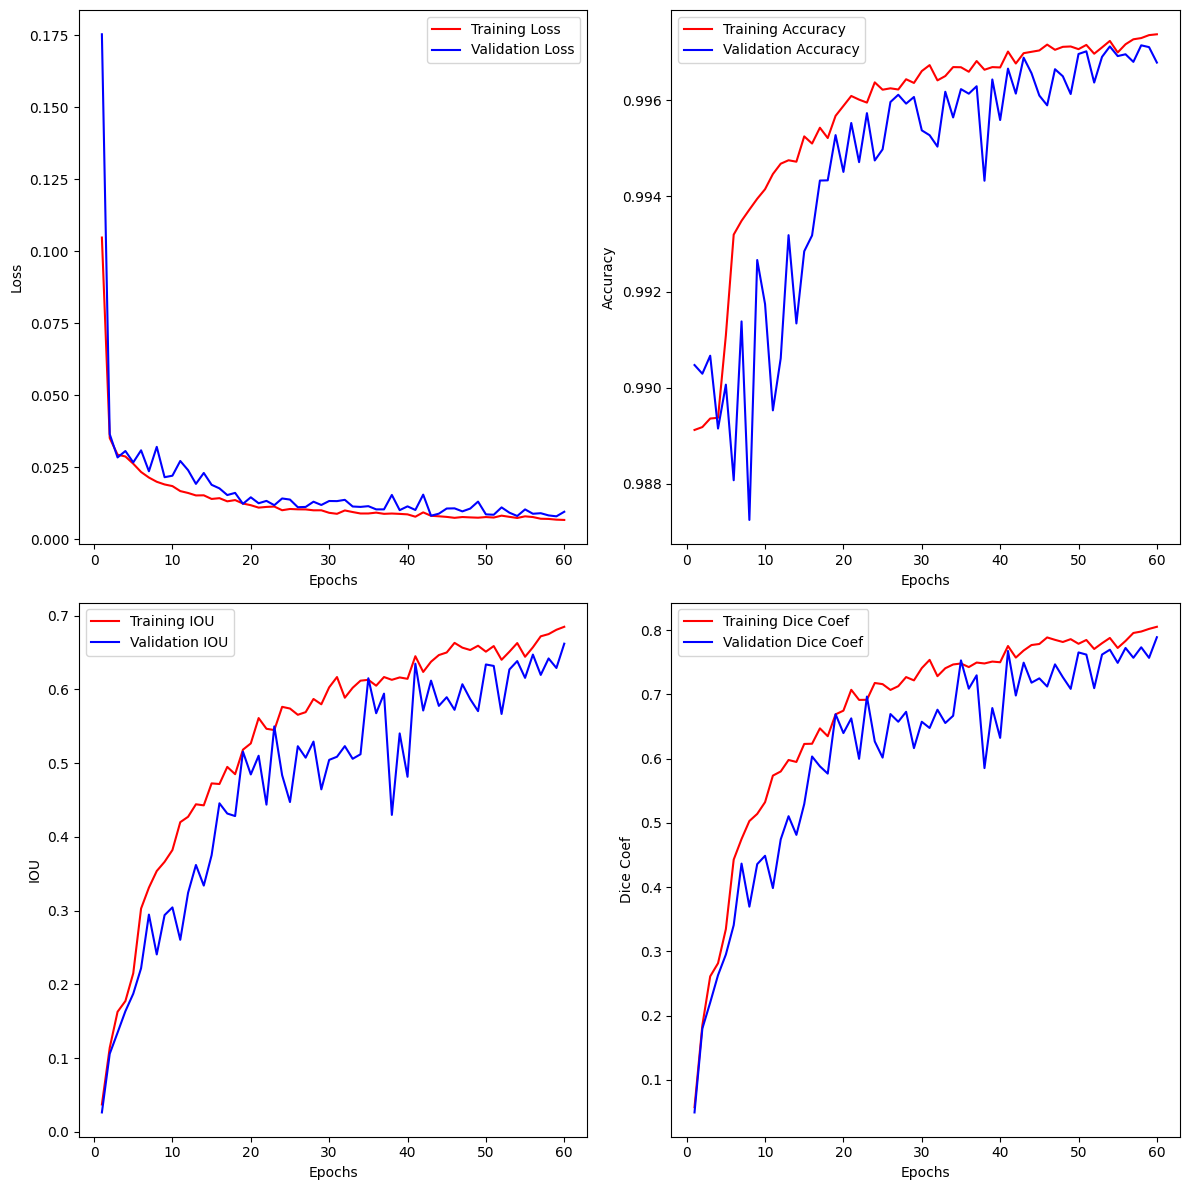

In [99]:
epochs = np.arange(1, num_epochs + 1)

plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.plot(epochs, history.history['loss'], 'r-', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], 'b-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, history.history['binary_accuracy'], 'r-', label='Training Accuracy')
plt.plot(epochs, history.history['val_binary_accuracy'], 'b-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(2, 2, 3)
plt.plot(epochs, history.history['iou'], 'r-', label='Training IOU')
plt.plot(epochs, history.history['val_iou'], 'b-', label='Validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs, history.history['dice_coef'], 'r-', label='Training Dice Coef')
plt.plot(epochs, history.history['val_dice_coef'], 'b-', label='Validation Dice Coef')
plt.xlabel('Epochs')
plt.ylabel('Dice Coef')
plt.legend()

plt.tight_layout()
plt.show()

In [100]:
# test_predict =
x_test = np.empty(shape=(test.shape[0], 128, 128, 3))
y_test = np.empty(shape=(test.shape[0], 128, 128, 1))
for i in range(test.shape[0]):
	img, mask = read_image(test.iloc[i]['image'], test.iloc[i]['mask'])
	img, mask = adjust_data(img, mask)
	x_test[i, :, :, :] = img
	y_test[i, :, :, 0] = mask
    
y_test_pred = model.predict(x_test)

13/13 [==============================] - 1s 64ms/step


In [101]:
test_dice_coef = dice_coef(
    tf.convert_to_tensor(y_test, dtype=tf.float32), 
    tf.convert_to_tensor(y_test_pred, dtype=tf.float32)
).numpy()
test_iou = iou(
    tf.convert_to_tensor(y_test, dtype=tf.float32), 
    tf.convert_to_tensor(y_test_pred, dtype=tf.float32)
).numpy()
m = tf.keras.metrics.BinaryAccuracy()
m.update_state(
	tf.convert_to_tensor(y_test, dtype=tf.float32), 
    tf.convert_to_tensor(y_test_pred, dtype=tf.float32)
)
test_accuracy = m.result().numpy()

print('test_dice_coef:', test_dice_coef)
print('test_iou:', test_iou)
print('test_accuracy', test_accuracy)


test_dice_coef: 0.75349486
test_iou: 0.6047337
test_accuracy 0.99630713


1/1 [==============================] - 0s 20ms/step


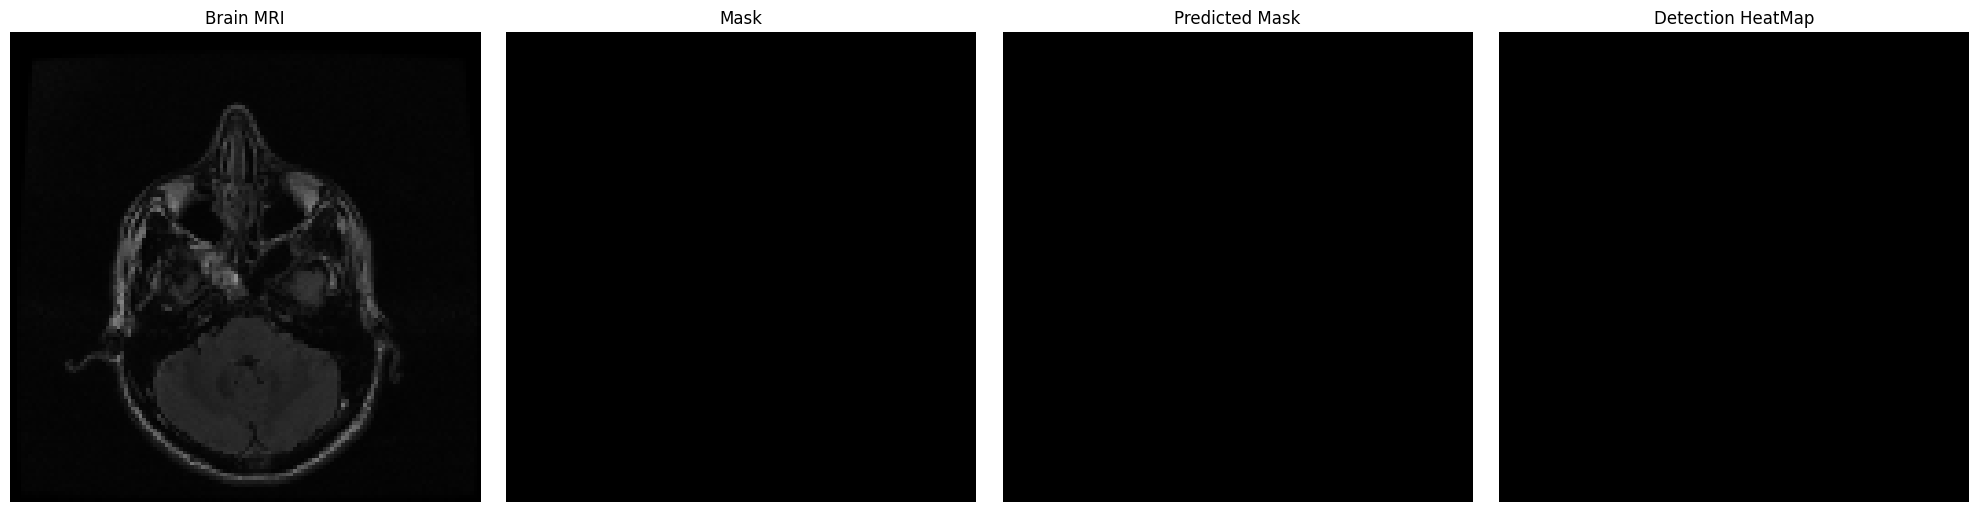

1/1 [==============================] - 0s 20ms/step


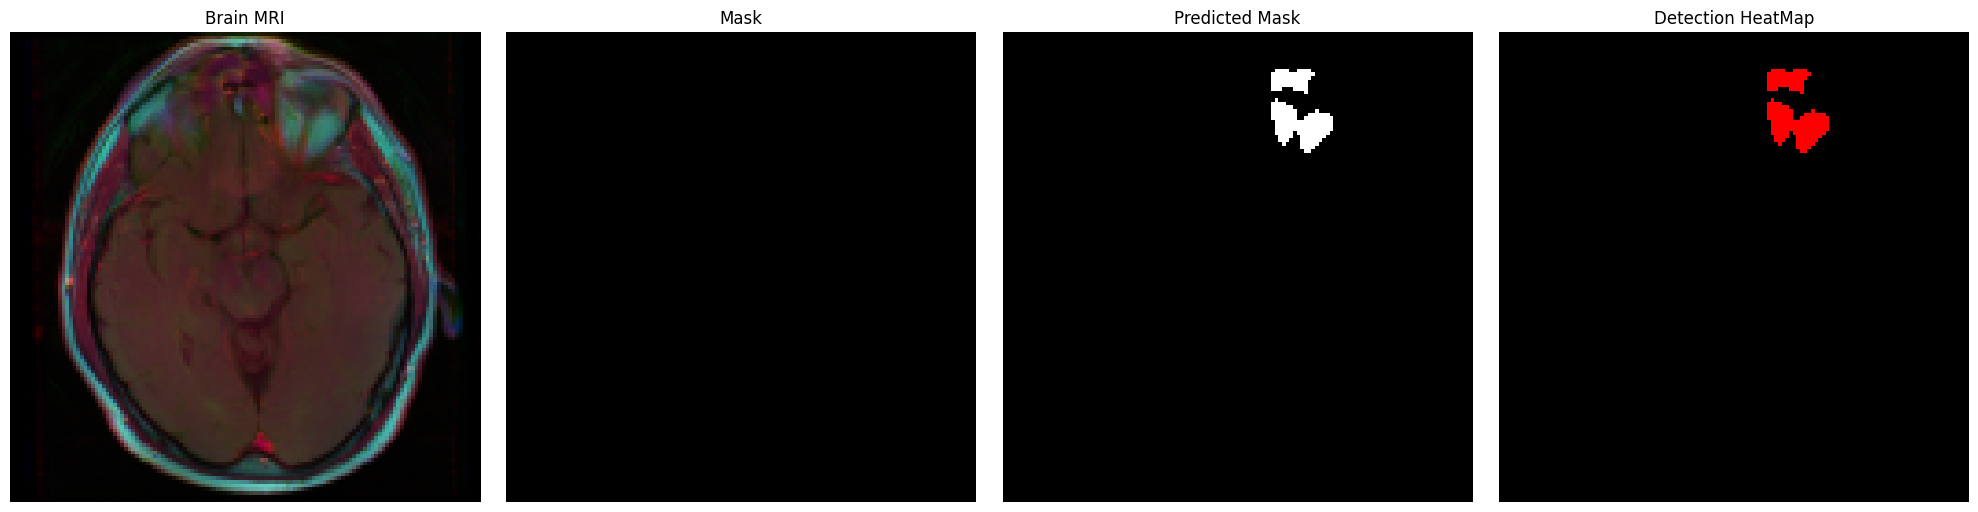

1/1 [==============================] - 0s 20ms/step


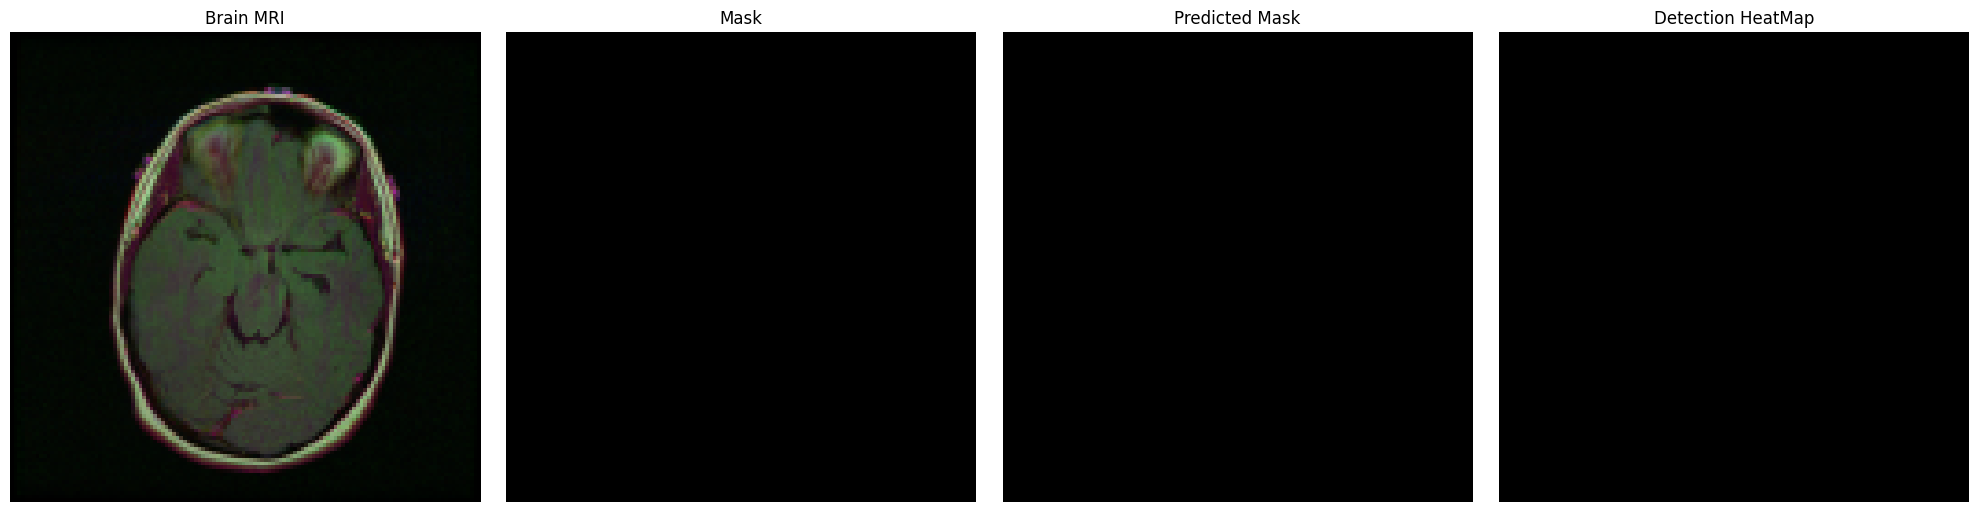

1/1 [==============================] - 0s 19ms/step


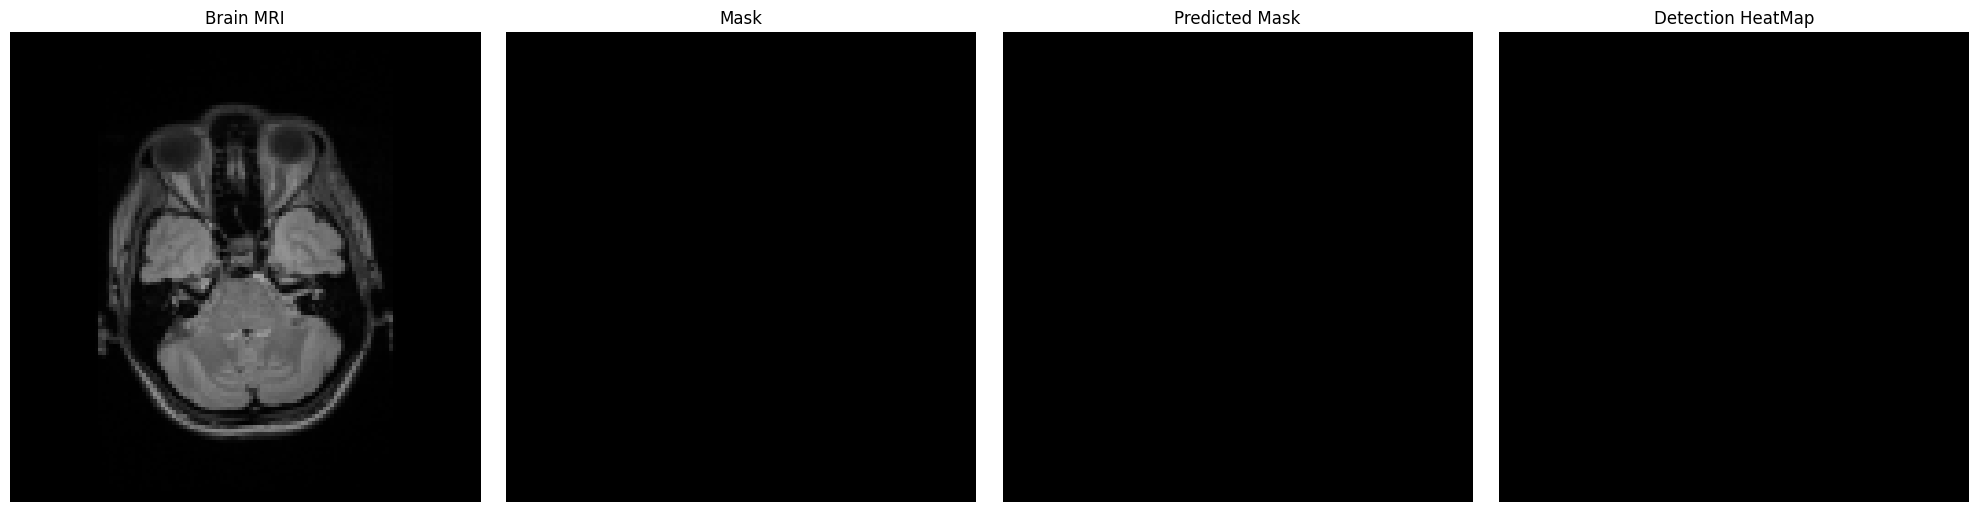

1/1 [==============================] - 0s 19ms/step


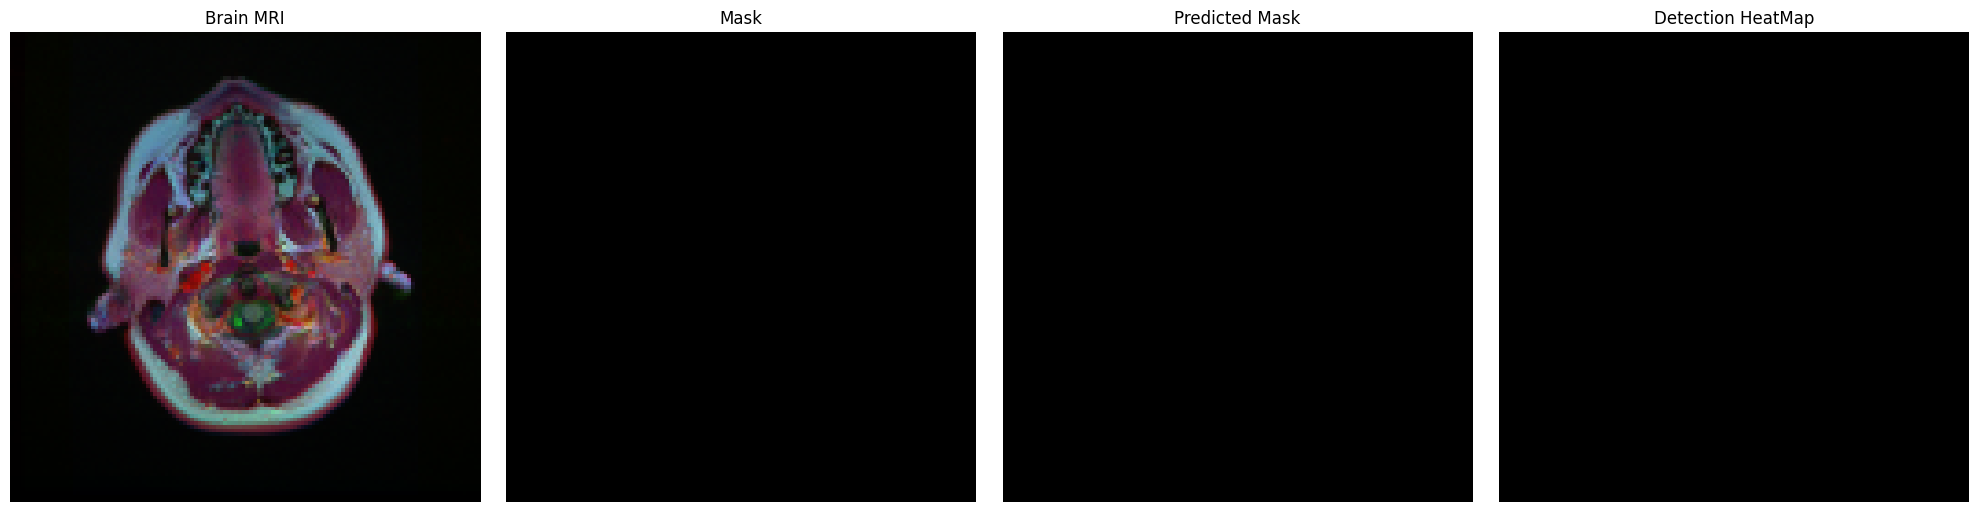

1/1 [==============================] - 0s 21ms/step


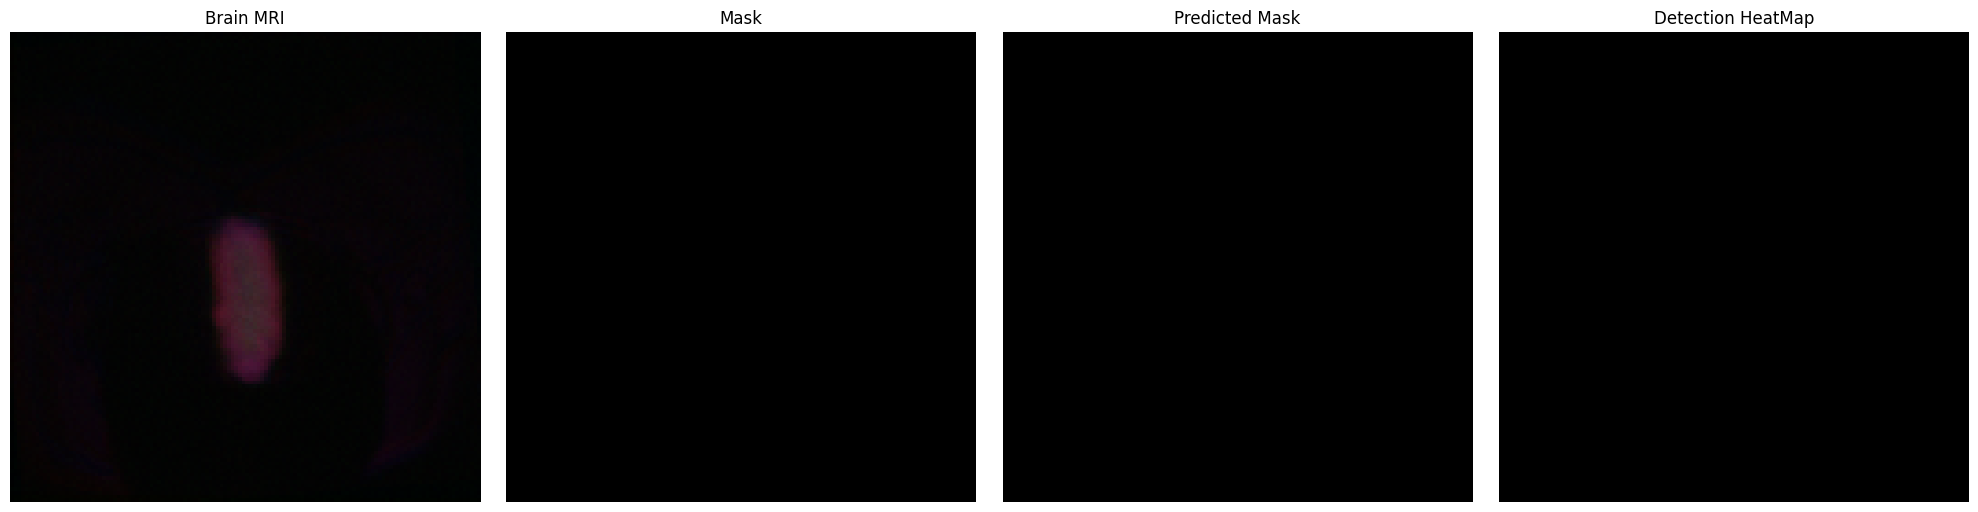

1/1 [==============================] - 0s 20ms/step


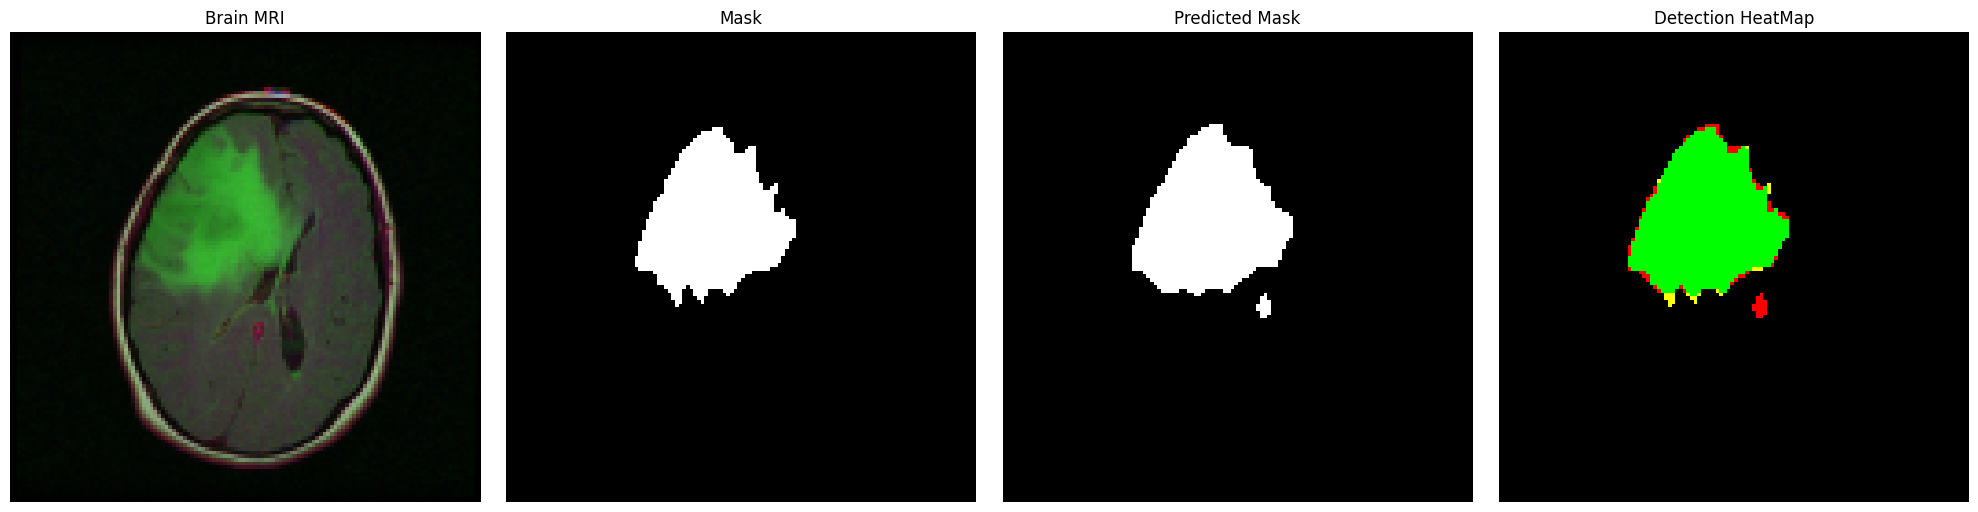

1/1 [==============================] - 0s 19ms/step


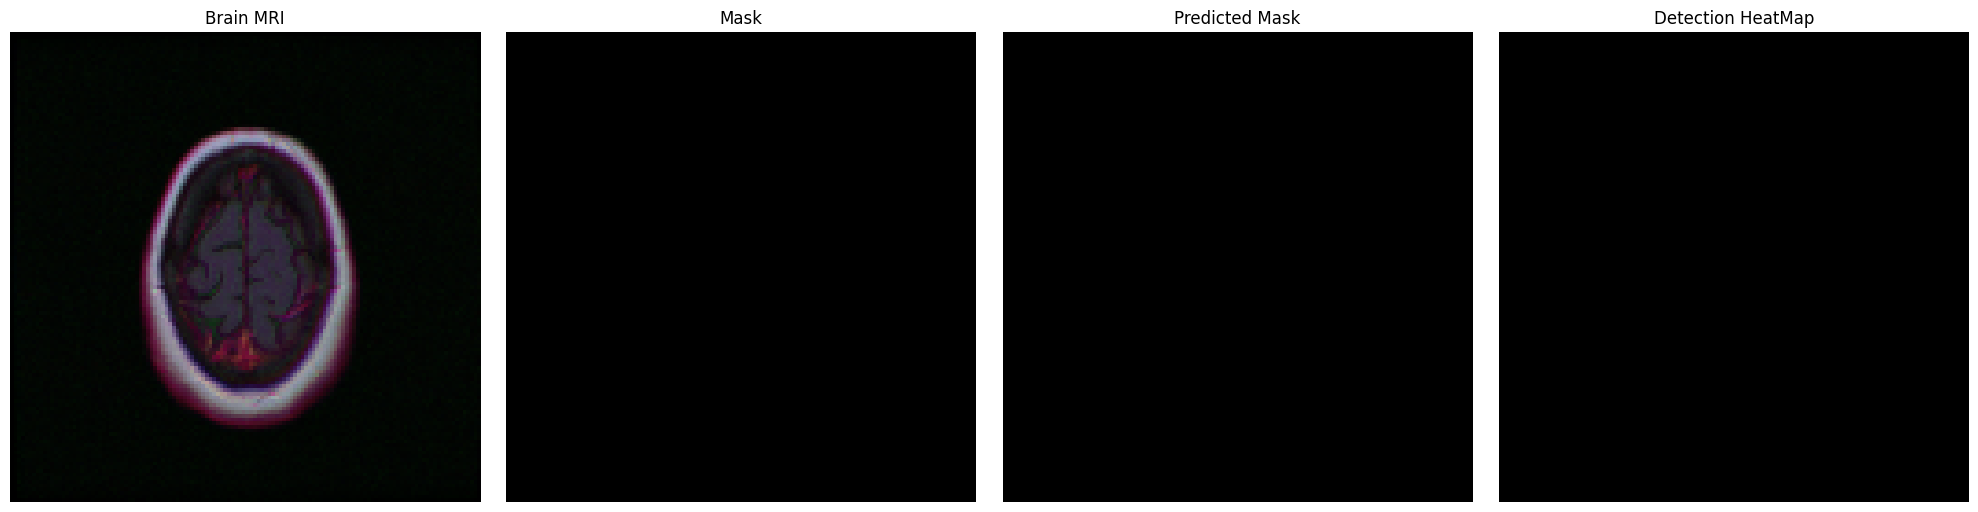

1/1 [==============================] - 0s 23ms/step


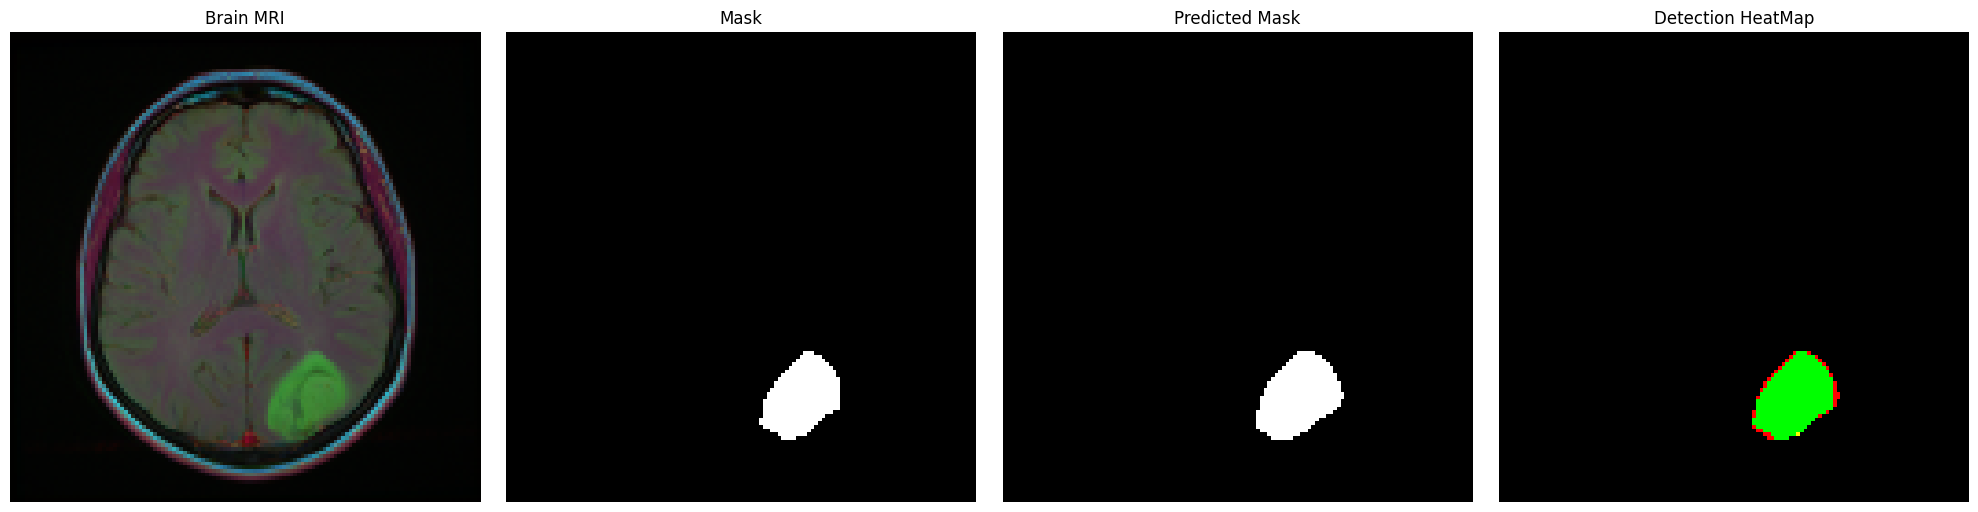

1/1 [==============================] - 0s 19ms/step


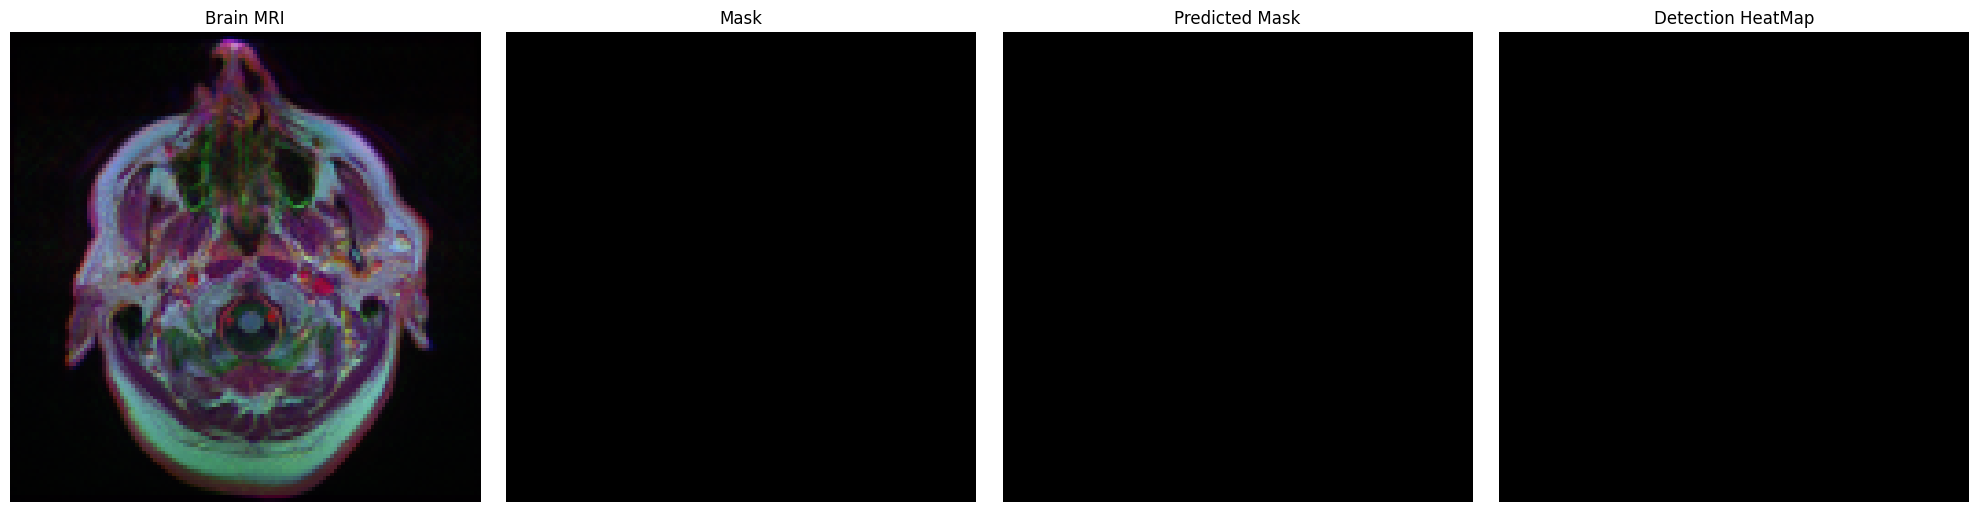

1/1 [==============================] - 0s 20ms/step


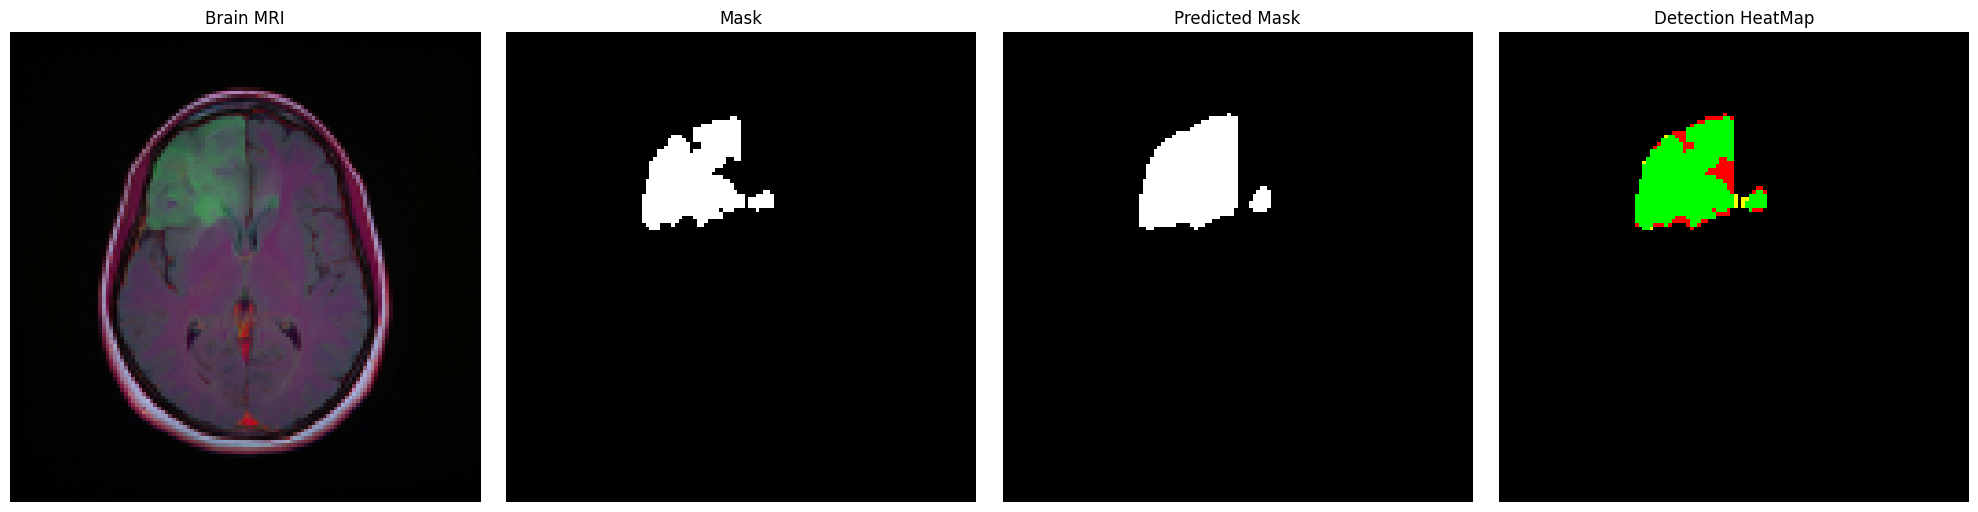

1/1 [==============================] - 0s 19ms/step


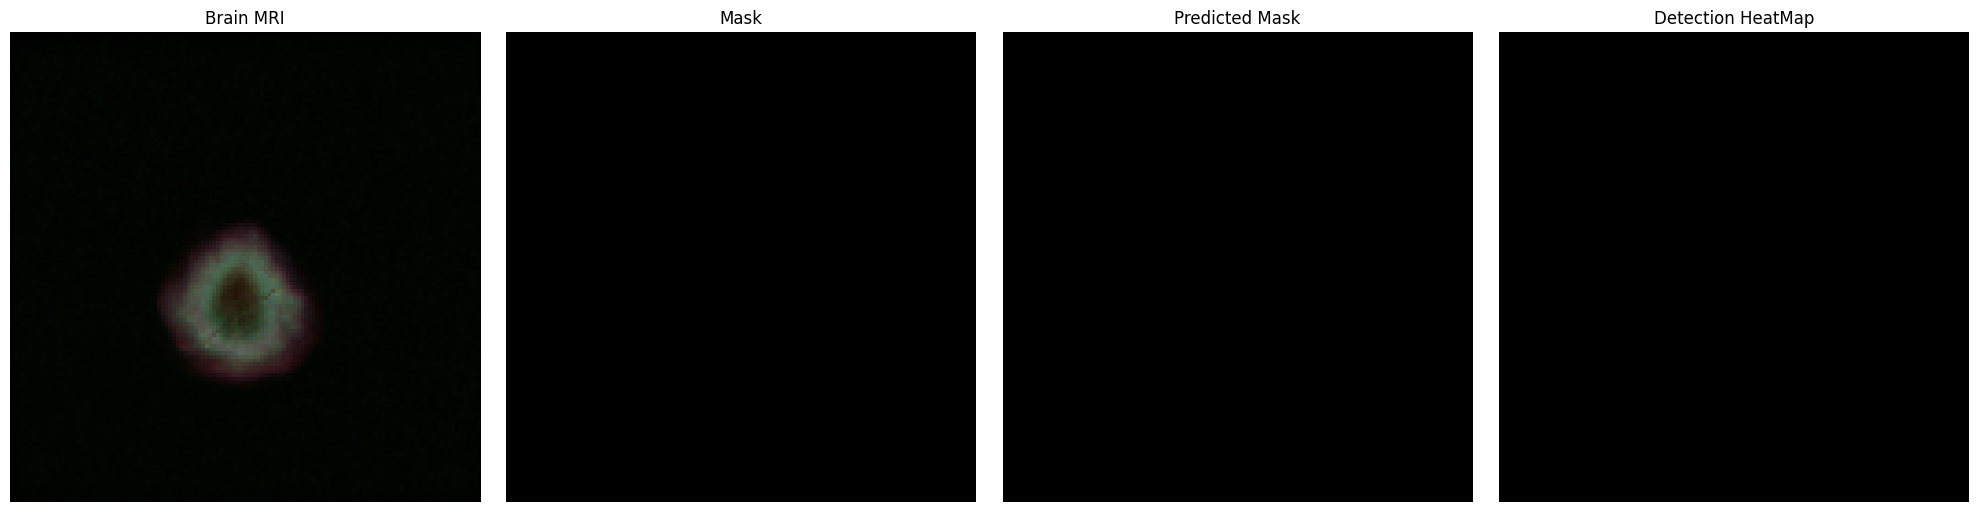

1/1 [==============================] - 0s 19ms/step


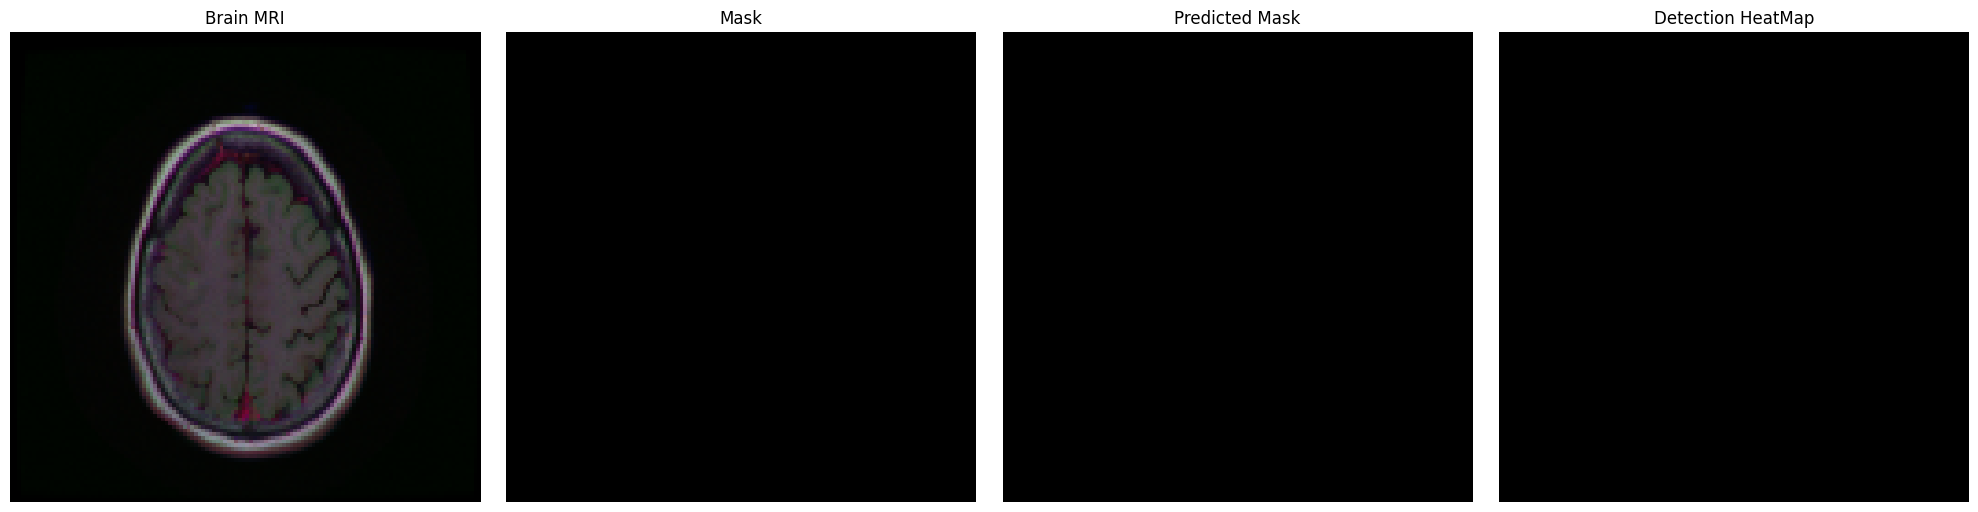

1/1 [==============================] - 0s 19ms/step


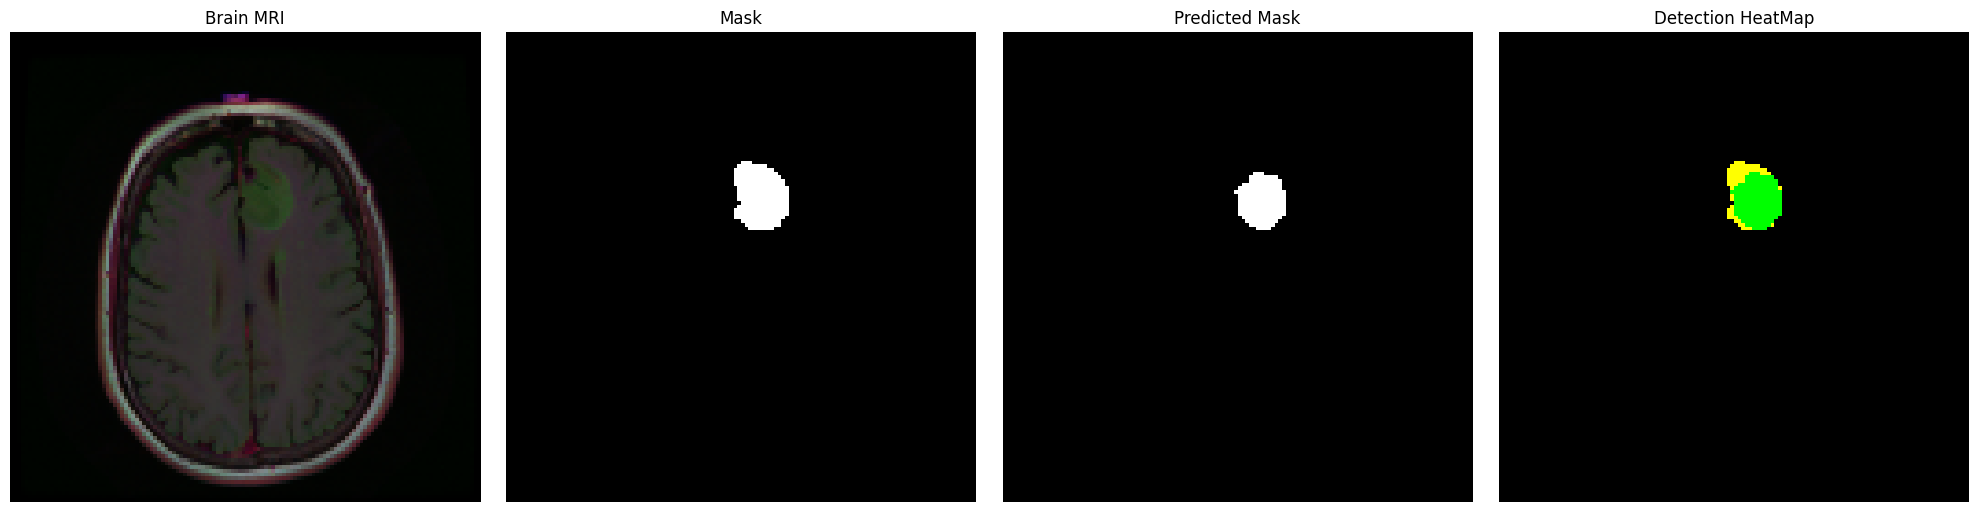

1/1 [==============================] - 0s 23ms/step


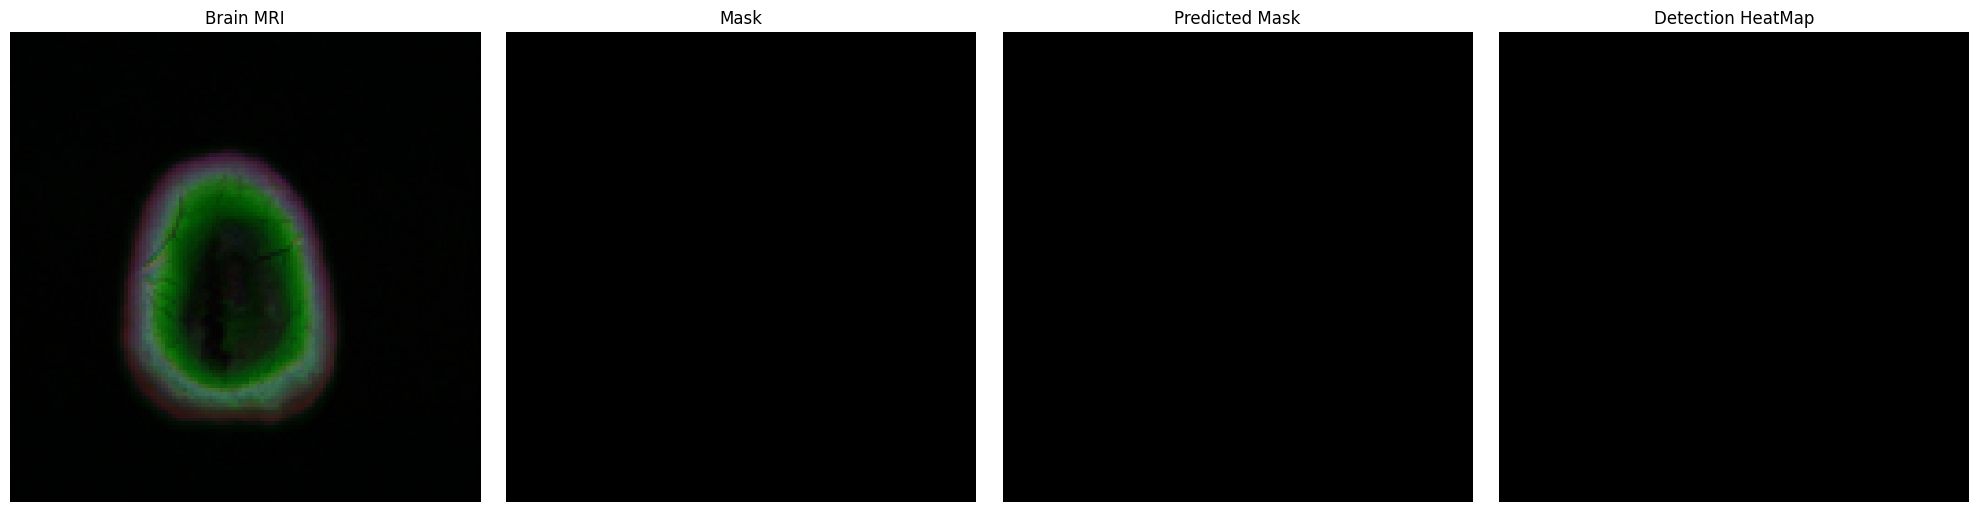

1/1 [==============================] - 0s 22ms/step


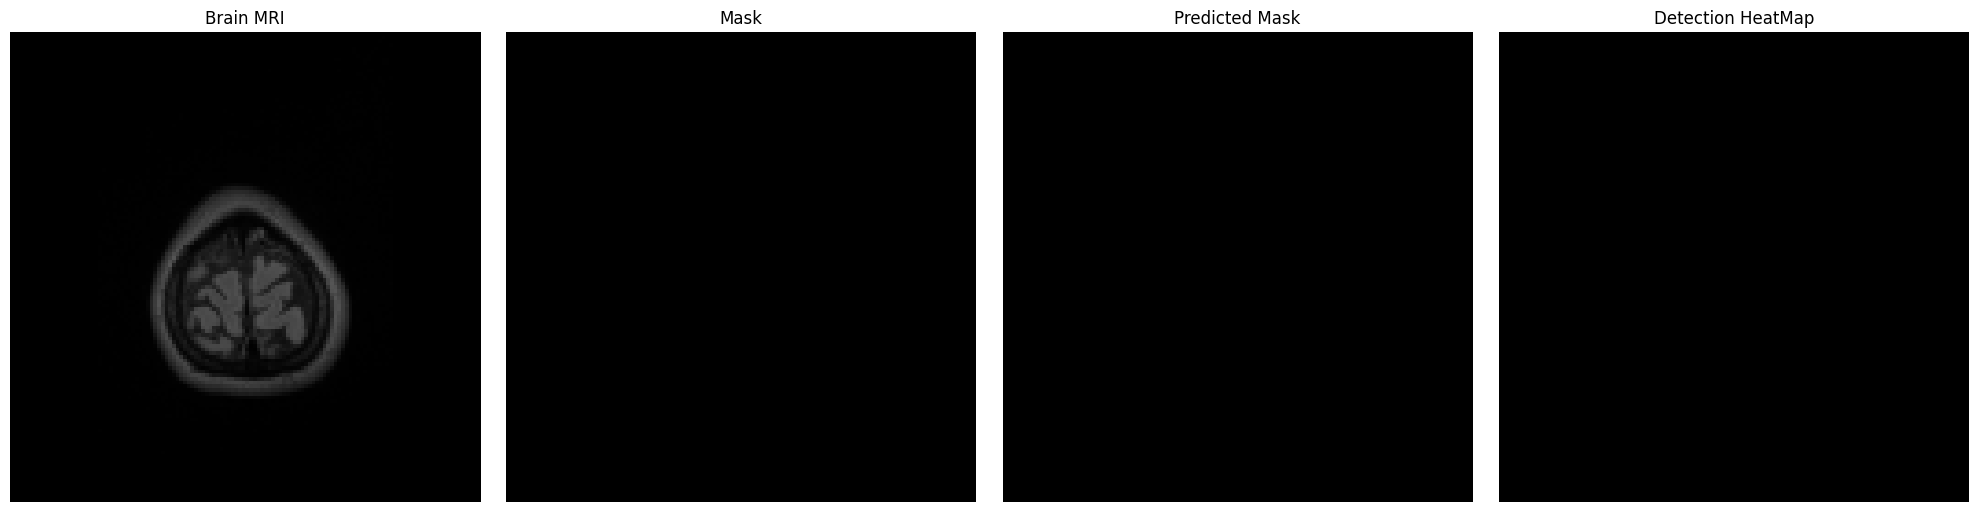

1/1 [==============================] - 0s 27ms/step


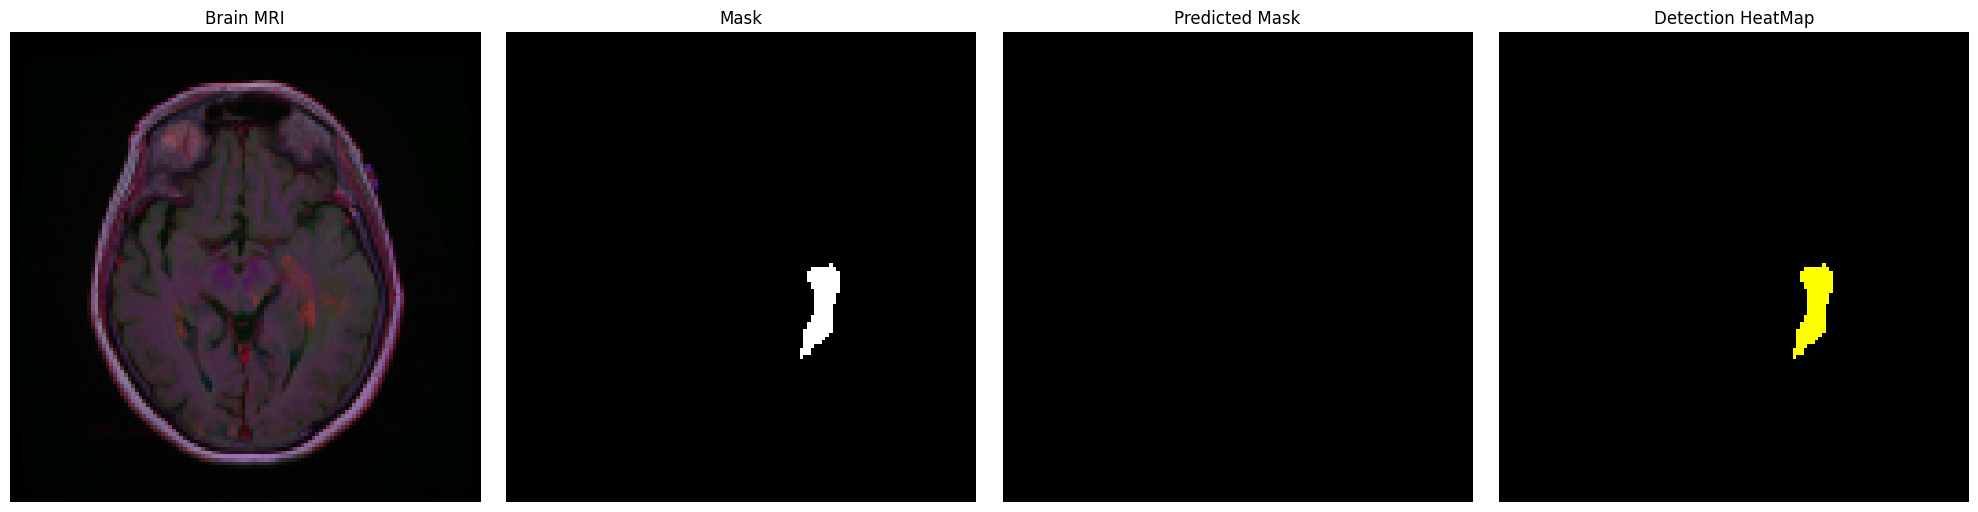

1/1 [==============================] - 0s 23ms/step


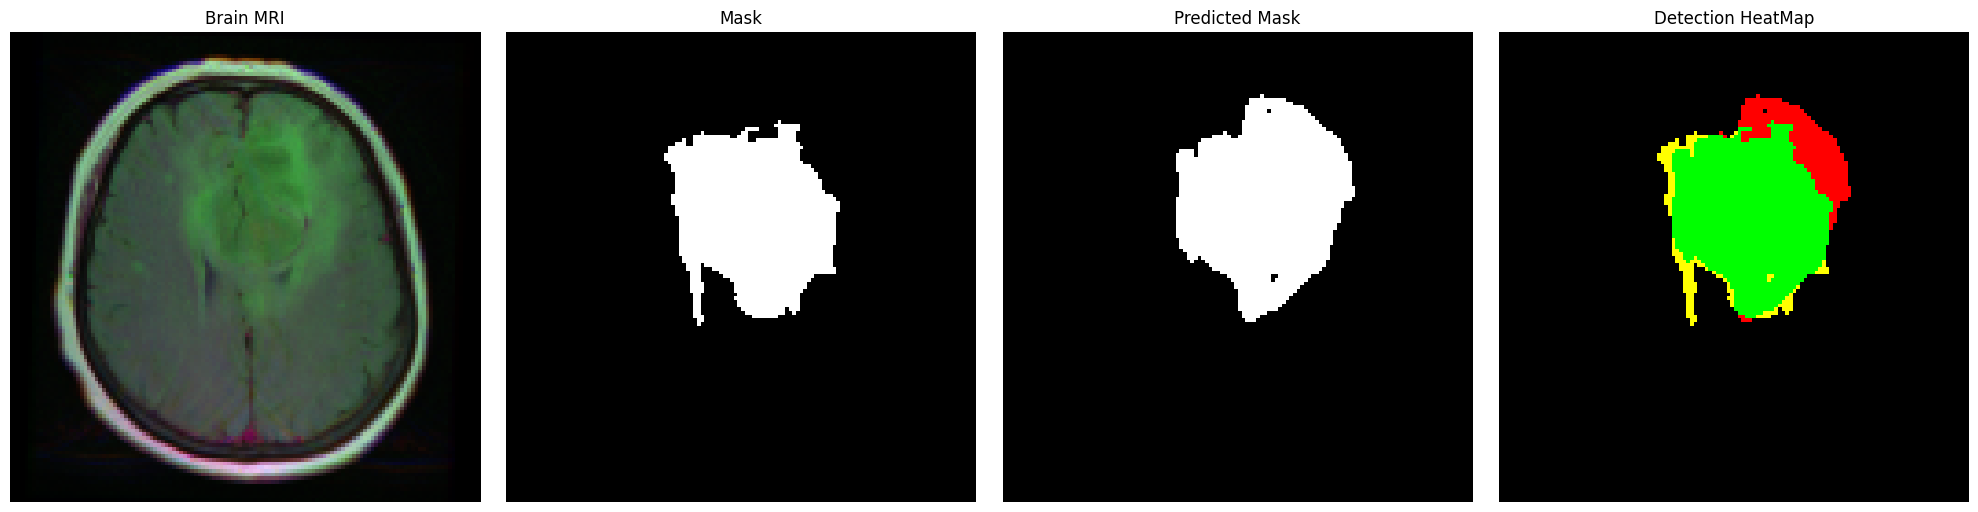

1/1 [==============================] - 0s 20ms/step


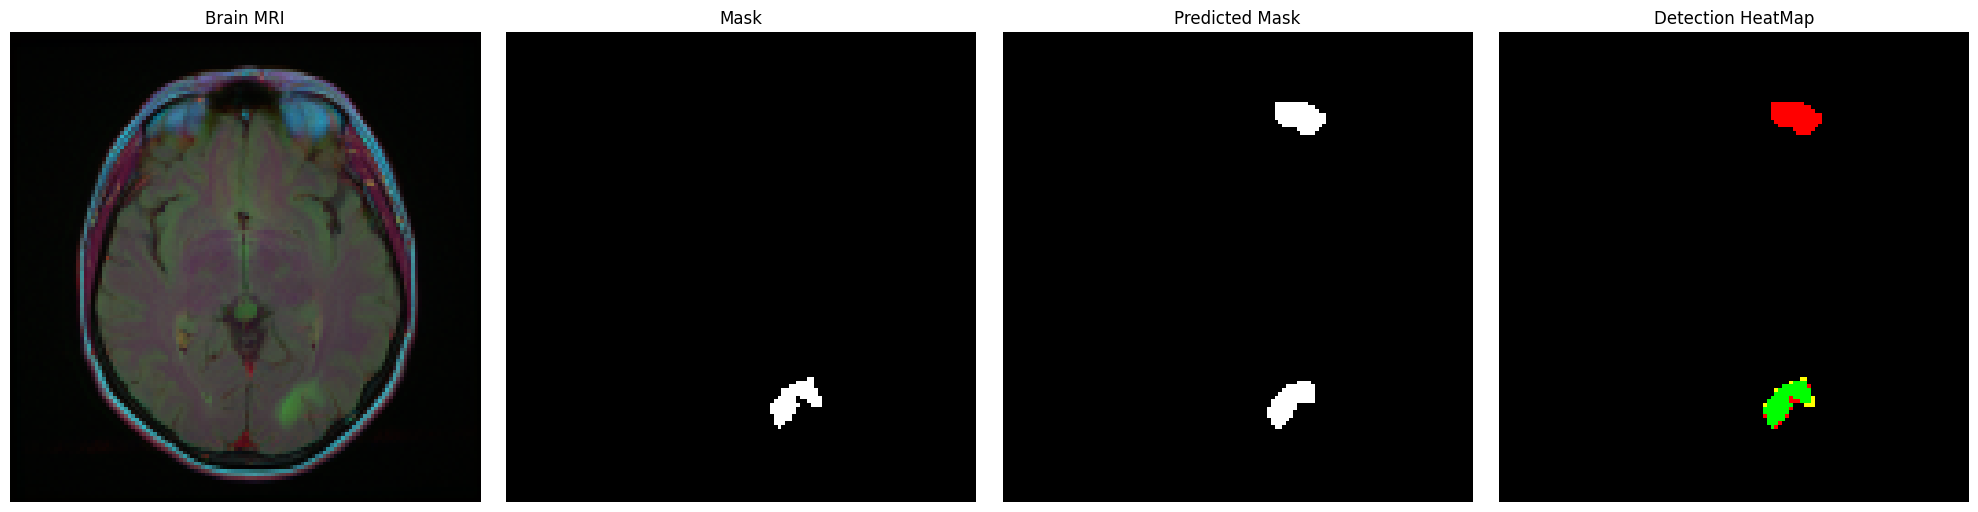

1/1 [==============================] - 0s 20ms/step


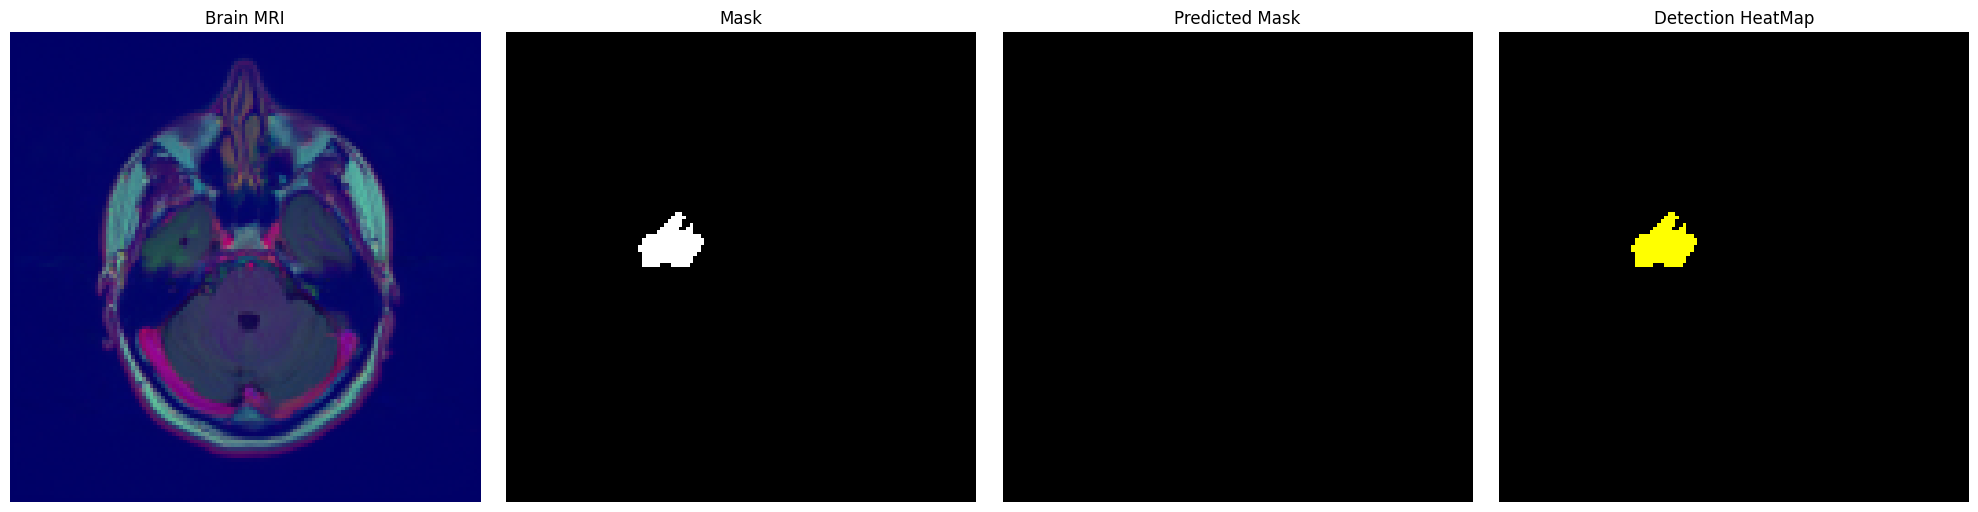

In [102]:
n_test = 20
for i in range(n_test):
	fig, axs = plt.subplots(1, 4, figsize=(20, 5))
	img, mask = read_image(test.iloc[i]['image'], test.iloc[i]['mask'])
	img, mask = adjust_data(img, mask)

	axs[0].title.set_text("Brain MRI")
	axs[0].axis('off')
	axs[0].imshow(img)
	
	axs[1].title.set_text('Mask')
	axs[1].axis('off')
	axs[1].imshow(mask, cmap='gray')
	
	img = img.reshape(1, 128, 128, 3)
	mask = mask.reshape(128, 128, 1)
	predicted = model.predict(img)
	predicted = predicted.reshape(128, 128, 1)
	predicted[predicted <= 0.5] = 0.0
	predicted[predicted > 0.5] = 1.0
	
	axs[2].title.set_text('Predicted Mask')
	axs[2].axis('off')
	axs[2].imshow(predicted, cmap='gray')

	not_tumor_correct = ((mask[:, :, 0] == 0.0) & (predicted[:, :, 0] == 0.0))
	tumor_correct = ((mask[:, :, 0] == 1.0) & (predicted[:, :, 0] == 1.0))
	not_tumor_uncorrect = ((mask[:, :, 0] == 0.0) & (predicted[:, :, 0] == 1.0))
	tumor_uncorrect = ((mask[:, :, 0] == 1.0) & (predicted[:, :, 0] == 0.0))

	detection = np.empty(shape=(128, 128, 3))
	detection[:, :, :3][not_tumor_correct] = [0.0, 0.0, 0.0]
	detection[:, :, :3][tumor_correct] = [0.0, 1.0, 0.0]
	detection[:, :, :3][not_tumor_uncorrect] = [1.0, 0.0, 0.0]
	detection[:, :, :3][tumor_uncorrect] = [1.0, 1.0, 0.0]

	axs[3].axis('off')
	axs[3].title.set_text('Detection HeatMap')
	axs[3].imshow(detection)
        
	fig.tight_layout()
	plt.show() 